## Finetune BERT with LoRA

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import label_binarize

from dotenv import load_dotenv
import os
os.environ["WANDB_DISABLED"] = "true"

from huggingface_hub import login

import evaluate

from datasets import load_dataset

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import logging

from peft import get_peft_model, LoraConfig, TaskType

import time

import torch

load_dotenv()

True

In [4]:
login(os.getenv('HUGGINGFACE_API_KEY'))

In [4]:
dataset = load_dataset('Jiahao123/FinancialPhraseBank_processed')

README.md:   0%|          | 0.00/547 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/349k [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/45.4k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/46.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3876 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/485 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/485 [00:00<?, ? examples/s]

### Initialize model

In [5]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1
)

In [6]:
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=3)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 297,219 || all params: 108,609,798 || trainable%: 0.2737


In [7]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

### Tokenize the text

In [8]:
def tokenize(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['index', 'label', 'text'],
        num_rows: 3876
    })
    validation: Dataset({
        features: ['index', 'label', 'text'],
        num_rows: 485
    })
    test: Dataset({
        features: ['index', 'label', 'text'],
        num_rows: 485
    })
})

In [10]:
dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

In [11]:
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

### Set up for training

In [12]:
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # convert the logits to their predicted class
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average='weighted')

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
device

'cuda'

In [15]:
training_args = TrainingArguments(
    output_dir="financial_classifier_peft",
    label_names=["labels"],
    learning_rate=1e-3,
    logging_steps=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    logging_strategy="steps",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to=None,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics
)

In [17]:
# train model
start_time = time.time()

trainer.train()

end_time = time.time()
print(f"Training took {end_time - start_time} seconds.")

Epoch,Training Loss,Validation Loss,F1
1,0.423600,0.502163,0.810581
2,0.300400,0.412228,0.848661
3,0.278900,0.469776,0.821474
4,0.164100,0.431755,0.858768
5,0.209800,0.530165,0.834997
6,0.153700,0.639325,0.835679
7,0.130400,0.666629,0.850853
8,0.082400,0.703296,0.854998
9,0.015700,0.736804,0.862823
10,0.057400,0.729027,0.863259


Training took 2051.3968250751495 seconds.


We can see that the model overfitted on the data. Training of the model took 2543 seconds.

In [18]:
trainer.push_to_hub("financial-sentiment-BERT")

Uploading...:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Jiahao123/financial_classifier_peft/commit/8d0671412e139b8d8c433fc9f0f6891833df77b5', commit_message='financial-sentiment-BERT', commit_description='', oid='8d0671412e139b8d8c433fc9f0f6891833df77b5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Jiahao123/financial_classifier_peft', endpoint='https://huggingface.co', repo_type='model', repo_id='Jiahao123/financial_classifier_peft'), pr_revision=None, pr_num=None)

In [19]:
tokenizer.push_to_hub("Jiahao123/financial_classifier_peft")

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Jiahao123/financial_classifier_peft/commit/1455a55cc44109072ee351bad0a217ab9d90f133', commit_message='Upload tokenizer', commit_description='', oid='1455a55cc44109072ee351bad0a217ab9d90f133', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Jiahao123/financial_classifier_peft', endpoint='https://huggingface.co', repo_type='model', repo_id='Jiahao123/financial_classifier_peft'), pr_revision=None, pr_num=None)

In [20]:
trainer.evaluate(dataset['validation'])

{'eval_loss': 0.4122280180454254,
 'eval_f1': 0.8486609028496539,
 'eval_runtime': 7.8212,
 'eval_samples_per_second': 62.011,
 'eval_steps_per_second': 3.964,
 'epoch': 10.0}

### Evaluate model performance

In [21]:
trainer.evaluate(dataset['test'])

{'eval_loss': 0.5278357267379761,
 'eval_f1': 0.8040543227534831,
 'eval_runtime': 7.8383,
 'eval_samples_per_second': 61.876,
 'eval_steps_per_second': 3.955,
 'epoch': 10.0}

In [22]:
predictions = trainer.predict(dataset["test"])

In [23]:
logits = predictions.predictions
labels = predictions.label_ids
probabilities = torch.softmax(torch.tensor(logits), dim=1).numpy()
preds = np.argmax(logits, axis=1)

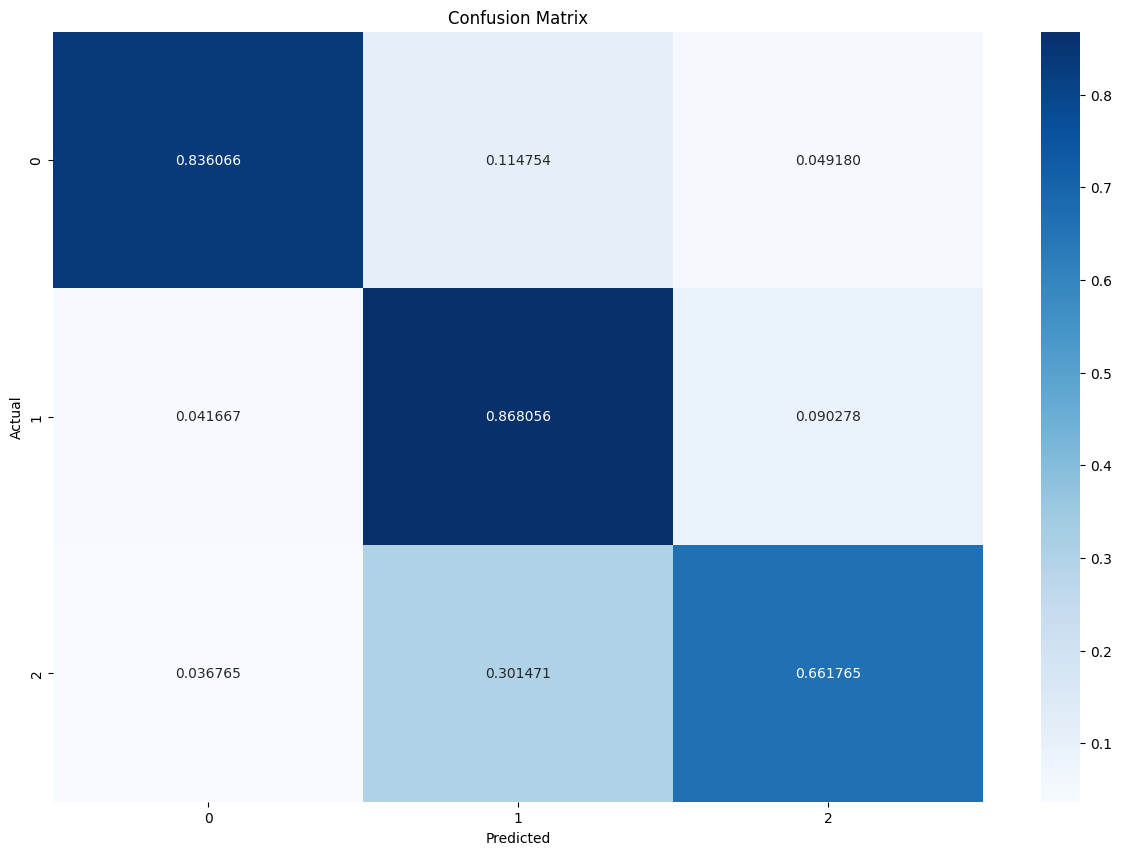

In [24]:
# confusion matrix
cm = confusion_matrix(labels, preds, normalize='true')
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='2f', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can see that the model seems to perform well for classes 0 and 1, and does poorly for class 2.

About 86% of negative sentiment were correctly predicted as negative, 87% of neutral sentiment were correctly predicted as neutral, while only 66% of positive news were correctly predicted as positive.

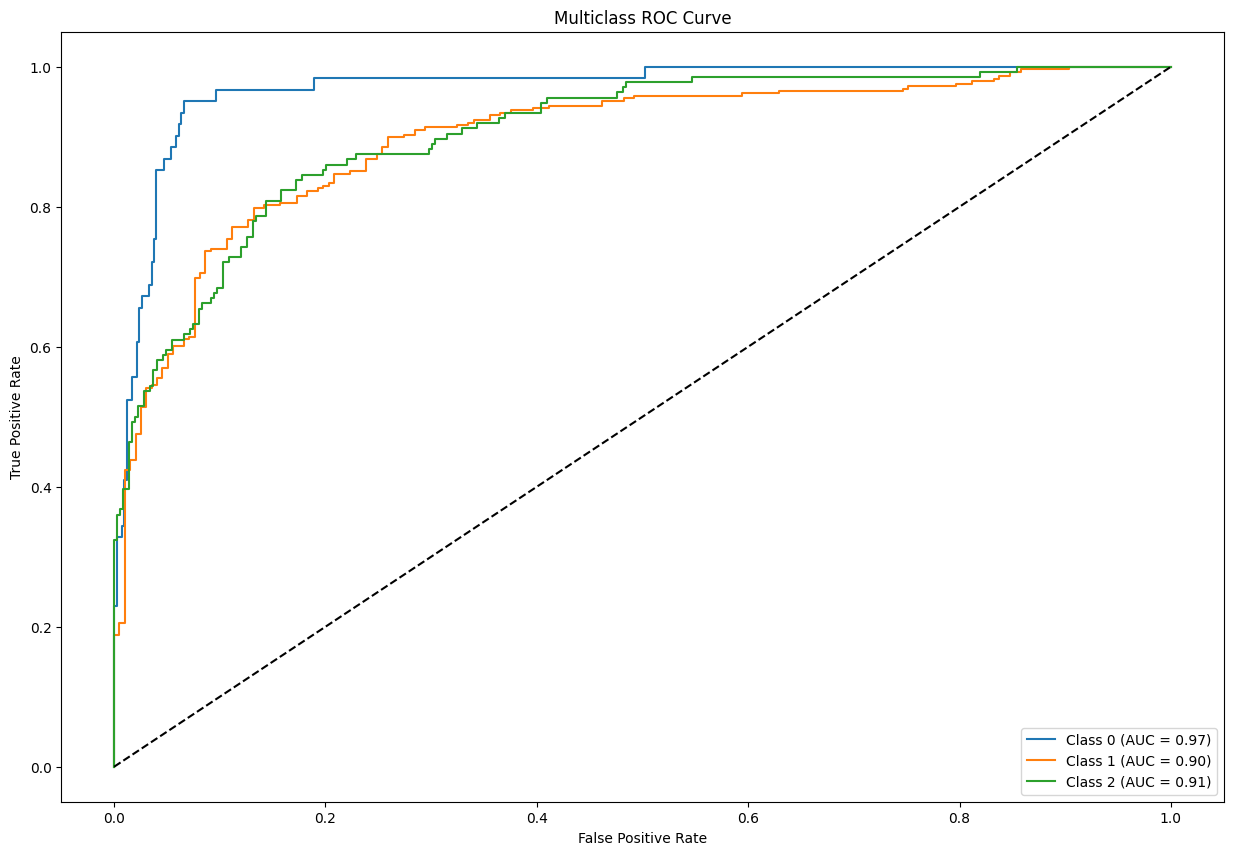

In [25]:
# roc curve for all 3 classes
# one vs all ROC curve
labels_onehot = label_binarize(labels, classes=[0, 1, 2])

plt.figure(figsize=(15, 10))
for i in range(3):
    fpr, tpr, _ = roc_curve(labels_onehot[:, i], probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend()
plt.show()

Model seems to be able to distinguish class 0 the best

In [26]:
report = classification_report(labels, preds)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.84      0.79        61
           1       0.84      0.87      0.85       288
           2       0.76      0.66      0.71       136

    accuracy                           0.81       485
   macro avg       0.78      0.79      0.78       485
weighted avg       0.80      0.81      0.80       485

